In [48]:
# ============================================================================
# STEP 1: Install Dependencies and Download Dataset
# ============================================================================

# Install required packages
%pip install -q kagglehub imbalanced-learn scikit-learn seaborn pandas numpy joblib

import kagglehub
import os
from pathlib import Path

# Download dataset
print("📥 Downloading CICIDS2018 dataset...")
dataset_path = kagglehub.dataset_download("dhoogla/csecicids2018")
print(f"✅ Dataset downloaded to: {dataset_path}")

Python(38124) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Note: you may need to restart the kernel to use updated packages.
📥 Downloading CICIDS2018 dataset...
✅ Dataset downloaded to: /Users/vivekvishnoi/.cache/kagglehub/datasets/dhoogla/csecicids2018/versions/3


In [49]:
# ============================================================================
# STEP 2: Import Libraries and Set Configuration
# ============================================================================

import gc
import numpy as np
import pandas as pd
import json
import joblib
import shutil
from typing import List, Tuple
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import seaborn as sns
import matplotlib.pyplot as plt

# Configuration
RANDOM_STATE = 42
NUMERIC_NA_FILL = 0.0
MAX_SAMPLES_PER_CLASS = 10000  # Adjust based on available memory

# Columns to exclude (non-feature columns)
EXCLUDE_COLS = {
    'Flow ID', 'Src IP', 'Dst IP', 'Timestamp', 
    'SimillarHTTP', 'Flow Byts/s', 'Flow Pkts/s'
}

# Memory optimization dtypes
FLOAT_DTYPES = {np.dtype('float64'): np.float32}
INT_DTYPES = {np.dtype('int64'): np.int32}

print("✅ Libraries imported and configuration set")


✅ Libraries imported and configuration set


In [50]:
# ============================================================================
# STEP 3: Define Helper Functions
# ============================================================================

def reduce_memory_usage(df: pd.DataFrame) -> pd.DataFrame:
    """Reduce memory usage by converting to smaller dtypes."""
    for col in df.columns:
        col_dtype = df[col].dtype
        if col_dtype in FLOAT_DTYPES:
            df[col] = df[col].astype(FLOAT_DTYPES[col_dtype])
        elif col_dtype in INT_DTYPES:
            df[col] = df[col].astype(INT_DTYPES[col_dtype])
    return df


def clean_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Remove non-feature columns and standardize label column name."""
    to_drop = [c for c in df.columns if c in EXCLUDE_COLS]
    if to_drop:
        df = df.drop(columns=to_drop)
    if 'label' in df.columns and 'Label' not in df.columns:
        df = df.rename(columns={'label': 'Label'})
    return df


def coerce_numeric(df: pd.DataFrame, exclude: List[str]) -> pd.DataFrame:
    """Convert object columns to numeric where possible."""
    for c in df.columns:
        if c in exclude:
            continue
        if df[c].dtype == 'object':
            df[c] = pd.to_numeric(df[c], errors='coerce')
    return df


def load_parquet_files(paths: List[str], label_col: str = 'Label') -> pd.DataFrame:
    """Load and combine multiple parquet files."""
    frames = []
    for p in paths:
        print(f"  Loading {os.path.basename(p)}...")
        part = pd.read_parquet(p)
        part = clean_columns(part)
        frames.append(part)
        del part
        gc.collect()
    
    df = pd.concat(frames, axis=0, ignore_index=True)
    del frames
    gc.collect()
    
    df = reduce_memory_usage(df)
    feature_cols = [c for c in df.columns if c != label_col]
    df = coerce_numeric(df, exclude=[label_col])
    df[feature_cols] = df[feature_cols].replace([np.inf, -np.inf], np.nan)
    df[feature_cols] = df[feature_cols].fillna(NUMERIC_NA_FILL)
    return df


def select_features(df: pd.DataFrame, label_col: str = 'Label') -> Tuple[pd.DataFrame, pd.Series]:
    """Extract numeric features and labels."""
    feature_cols = [c for c in df.columns if c != label_col and pd.api.types.is_numeric_dtype(df[c])]
    X = df[feature_cols].copy()
    y = df[label_col].copy()
    return X, y

print("✅ Helper functions defined")

✅ Helper functions defined


In [51]:
# ============================================================================
# STEP 4: Load and Preprocess Dataset
# ============================================================================

# Define dataset file paths
parquet_files = [
    "DDoS1-Tuesday-20-02-2018_TrafficForML_CICFlowMeter.parquet",
    "Web1-Thursday-22-02-2018_TrafficForML_CICFlowMeter.parquet",
    "Botnet-Friday-02-03-2018_TrafficForML_CICFlowMeter.parquet",
    "DDoS2-Wednesday-21-02-2018_TrafficForML_CICFlowMeter.parquet",
    "Web2-Friday-23-02-2018_TrafficForML_CICFlowMeter.parquet",
    "DoS2-Friday-16-02-2018_TrafficForML_CICFlowMeter.parquet",
    "DoS1-Thursday-15-02-2018_TrafficForML_CICFlowMeter.parquet",
    "Infil1-Wednesday-28-02-2018_TrafficForML_CICFlowMeter.parquet",
    "Infil2-Thursday-01-03-2018_TrafficForML_CICFlowMeter.parquet",
    "Bruteforce-Wednesday-14-02-2018_TrafficForML_CICFlowMeter.parquet",
]

file_paths = [os.path.join(dataset_path, f) for f in parquet_files]

# Load and combine all parquet files
print("📊 Loading dataset files...")
raw_df = load_parquet_files(file_paths)
print(f"✅ Combined dataset shape: {raw_df.shape}")
# Extract features and labels
X_all, y_all = select_features(raw_df, label_col='Label')
print(f"✅ Features extracted: {X_all.shape[1]} features")

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y_all)
print(f"\n✅ Label encoding completed. Classes ({len(le.classes_)}):")
for i, cls in enumerate(le.classes_):
    print(f"   {i} → {cls}")

# Clean up
del raw_df
gc.collect()


📊 Loading dataset files...
  Loading DDoS1-Tuesday-20-02-2018_TrafficForML_CICFlowMeter.parquet...
  Loading Web1-Thursday-22-02-2018_TrafficForML_CICFlowMeter.parquet...
  Loading Botnet-Friday-02-03-2018_TrafficForML_CICFlowMeter.parquet...
  Loading DDoS2-Wednesday-21-02-2018_TrafficForML_CICFlowMeter.parquet...
  Loading Web2-Friday-23-02-2018_TrafficForML_CICFlowMeter.parquet...
  Loading DoS2-Friday-16-02-2018_TrafficForML_CICFlowMeter.parquet...
  Loading DoS1-Thursday-15-02-2018_TrafficForML_CICFlowMeter.parquet...
  Loading Infil1-Wednesday-28-02-2018_TrafficForML_CICFlowMeter.parquet...
  Loading Infil2-Thursday-01-03-2018_TrafficForML_CICFlowMeter.parquet...
  Loading Bruteforce-Wednesday-14-02-2018_TrafficForML_CICFlowMeter.parquet...
✅ Combined dataset shape: (6659532, 78)
✅ Features extracted: 77 features

✅ Label encoding completed. Classes (15):
   0 → Benign
   1 → Bot
   2 → Brute Force -Web
   3 → Brute Force -XSS
   4 → DDOS attack-HOIC
   5 → DDOS attack-LOIC-UDP
 

0

In [52]:
# ============================================================================
# STEP 5: Balance Dataset and Split Train/Test
# ============================================================================

print("⚖️  Balancing dataset...")

# Create temporary dataframe for stratified sampling
tmp_df = X_all.copy()
tmp_df['Label_encoded'] = y_encoded

# Stratified downsampling per class
balanced_df = (
    tmp_df.groupby('Label_encoded', group_keys=False)
    .apply(lambda x: x.sample(min(len(x), MAX_SAMPLES_PER_CLASS), random_state=RANDOM_STATE))
    .reset_index(drop=True)
)

# Split back into features and labels
X_bal = balanced_df.drop(columns=['Label_encoded'])
y_bal = balanced_df['Label_encoded']

print(f"✅ Balanced dataset shape: {X_bal.shape}")
print(f"\n📊 Class distribution after balancing:")
print(pd.Series(y_bal).value_counts().sort_index())

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=RANDOM_STATE, stratify=y_bal
)

print(f"\n✅ Train/Test split completed:")
print(f"   Training: {X_train.shape[0]} samples")
print(f"   Testing:  {X_test.shape[0]} samples")
print(f"   Features: {X_train.shape[1]}")

# Clean up
del tmp_df, balanced_df, X_all, y_all, X_bal, y_bal
gc.collect()


⚖️  Balancing dataset...


/var/folders/15/4w504wk53_939rqfm38kw6c40000gn/T/ipykernel_38601/3230355553.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), MAX_SAMPLES_PER_CLASS), random_state=RANDOM_STATE))


✅ Balanced dataset shape: (92628, 77)

📊 Class distribution after balancing:
Label_encoded
0     10000
1     10000
2       568
3       229
4     10000
5      1730
6     10000
7     10000
8     10000
9        55
10     9908
11       53
12    10000
13       85
14    10000
Name: count, dtype: int64

✅ Train/Test split completed:
   Training: 74102 samples
   Testing:  18526 samples
   Features: 77


0

🤖 Training HistGradientBoostingClassifier...

✅ Training completed!
📊 Macro F1 Score: 0.7358

📋 Classification Report:
              precision    recall  f1-score   support

           0      0.876     0.609     0.719      2000
           1      0.995     0.988     0.991      2000
           2      0.802     0.675     0.733       114
           3      0.528     0.609     0.566        46
           4      0.997     0.998     0.997      2000
           5      0.986     1.000     0.993       346
           6      0.994     0.998     0.996      2000
           7      0.999     0.988     0.993      2000
           8      1.000     1.000     1.000      2000
           9      0.133     0.182     0.154        11
          10      0.992     0.994     0.993      1982
          11      0.000     0.000     0.000        10
          12      0.692     0.874     0.772      2000
          13      0.075     0.471     0.130        17
          14      1.000     1.000     1.000      2000

    accuracy   

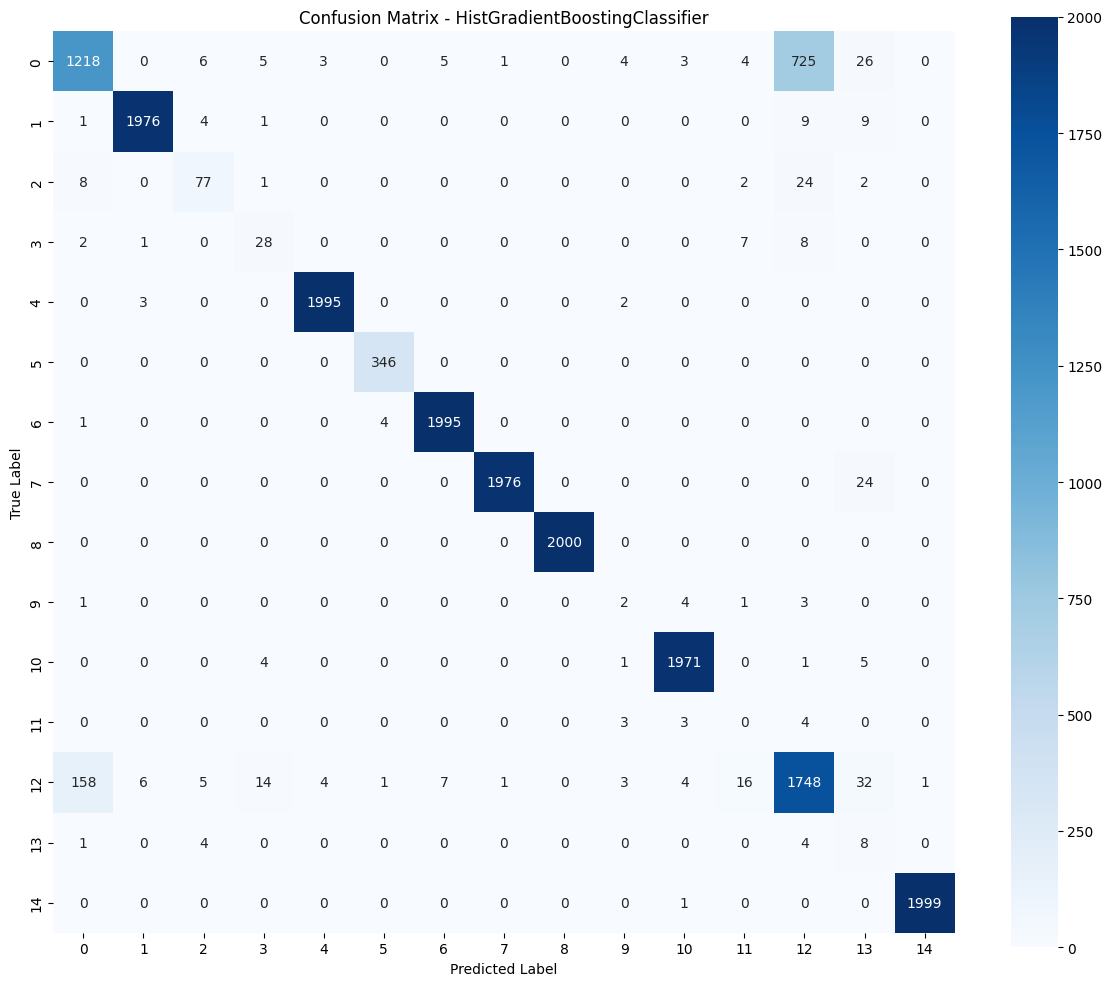


✅ Model evaluation complete!


In [53]:
# ============================================================================
# STEP 6: Train Model
# ============================================================================

print("🤖 Training HistGradientBoostingClassifier...")

# Train classifier directly (dataset already balanced above)
pipeline = ImbPipeline(steps=[
    ('clf', HistGradientBoostingClassifier(
        learning_rate=0.1,
        max_depth=None,
        max_leaf_nodes=31,
        early_stopping=True,
        random_state=RANDOM_STATE
    ))
])

# Train model
pipeline.fit(X_train, y_train)

# Evaluate on test set
y_pred = pipeline.predict(X_test)
macro_f1 = f1_score(y_test, y_pred, average='macro')

print(f"\n✅ Training completed!")
print(f"📊 Macro F1 Score: {macro_f1:.4f}")
print(f"\n📋 Classification Report:")
print(classification_report(y_test, y_pred, digits=3))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True, cbar=True)
plt.title('Confusion Matrix - HistGradientBoostingClassifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

print("\n✅ Model evaluation complete!")


In [54]:
# ============================================================================
# STEP 7: Save Model and Artifacts for Deployment
# ============================================================================

# Define project paths
project_root = Path.cwd()
artifacts_dir = project_root / "artifacts"
backend_models_dir = project_root / "backend" / "models"

# Create directories
artifacts_dir.mkdir(exist_ok=True)
backend_models_dir.mkdir(exist_ok=True)

# Save model and label encoder to both locations
model_name = "ids_tuned_hist_gb"
model_path_project = artifacts_dir / f"{model_name}.joblib"
model_path_backend = backend_models_dir / f"{model_name}.joblib"

le_path_project = artifacts_dir / "label_encoder.joblib"
le_path_backend = backend_models_dir / "label_encoder.joblib"

# Save files
joblib.dump(pipeline, model_path_project)
joblib.dump(le, le_path_project)

# Copy to backend/models for Flask app
shutil.copy(model_path_project, model_path_backend)
shutil.copy(le_path_project, le_path_backend)

print("💾 Model artifacts saved:")
print(f"   📁 {model_path_project}")
print(f"   📁 {model_path_backend}")
print(f"   📁 {le_path_project}")
print(f"   📁 {le_path_backend}")

# Save model metadata
metadata = {
    "model_name": model_name,
    "model_type": "HistGradientBoostingClassifier",
    "num_classes": len(le.classes_),
    "classes": le.classes_.tolist(),
    "training_samples": int(len(X_train)),
    "test_samples": int(len(X_test)),
    "num_features": int(X_train.shape[1]),
    "macro_f1": float(macro_f1),
    "feature_names": X_train.columns.tolist()
}

metadata_path = artifacts_dir / "model_metadata.json"
metadata_path_backend = backend_models_dir / "model_metadata.json"

with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
shutil.copy(metadata_path, metadata_path_backend)

print(f"\n✅ Model metadata saved:")
print(f"   📁 {metadata_path}")
print(f"   📁 {metadata_path_backend}")

print("\n🎉 Model successfully saved and ready for deployment!")


💾 Model artifacts saved:
   📁 /Users/vivekvishnoi/Desktop/cn project/artifacts/ids_tuned_hist_gb.joblib
   📁 /Users/vivekvishnoi/Desktop/cn project/backend/models/ids_tuned_hist_gb.joblib
   📁 /Users/vivekvishnoi/Desktop/cn project/artifacts/label_encoder.joblib
   📁 /Users/vivekvishnoi/Desktop/cn project/backend/models/label_encoder.joblib

✅ Model metadata saved:
   📁 /Users/vivekvishnoi/Desktop/cn project/artifacts/model_metadata.json
   📁 /Users/vivekvishnoi/Desktop/cn project/backend/models/model_metadata.json

🎉 Model successfully saved and ready for deployment!


In [55]:
# ============================================================================
# STEP 8: Inference Helper Functions (Optional)
# ============================================================================

def load_artifacts(model_path=None, le_path=None):
    """Load trained model and label encoder."""
    if model_path is None:
        model_path = backend_models_dir / f"{model_name}.joblib"
    if le_path is None:
        le_path = backend_models_dir / "label_encoder.joblib"
    
    model = joblib.load(model_path)
    label_enc = joblib.load(le_path)
    return model, label_enc


def predict_flows(df_new: pd.DataFrame, model=None, label_enc=None):
    """Predict labels for new flow data."""
    if model is None or label_enc is None:
        model, label_enc = load_artifacts()
    
    df_new = clean_columns(df_new)
    df_new = reduce_memory_usage(df_new)
    X_new, _ = select_features(df_new, label_col='Label')
    
    # Ensure feature order matches training
    # This assumes all training features are present in new data
    preds = model.predict(X_new)
    labels = label_enc.inverse_transform(preds)
    
    out = df_new.copy()
    out['predicted_label'] = labels
    return out

print("✅ Inference helper functions defined")
print("\n📝 Usage example:")
print("   model, label_enc = load_artifacts()")
print("   df_new = pd.read_parquet('new_data.parquet')")
print("   predictions = predict_flows(df_new, model, label_enc)")


✅ Inference helper functions defined

📝 Usage example:
   model, label_enc = load_artifacts()
   df_new = pd.read_parquet('new_data.parquet')
   predictions = predict_flows(df_new, model, label_enc)


In [56]:
# ============================================================================
# STEP 9: Quick Sanity Check on Benign Samples
# ============================================================================

import pandas as pd

try:
    df_sample = pd.read_csv("cic_ids_test_sample.csv")
    df_sample = clean_columns(df_sample)
    df_sample = reduce_memory_usage(df_sample)
    # take up to 50 benign rows if present
    if 'Label' in df_sample.columns:
        benign_rows = df_sample[df_sample['Label'] == 'Benign'].head(50)
    else:
        benign_rows = df_sample.head(50)
    X_check, y_check = select_features(benign_rows, label_col='Label')
    y_pred_check = pipeline.predict(X_check)
    labels_check = le.inverse_transform(y_pred_check)
    print("Benign sanity-check predictions (counts):")
    print(pd.Series(labels_check).value_counts())
except Exception as e:
    print(f"Sanity check failed: {e}")



Benign sanity-check predictions (counts):
Benign              32
Infilteration       16
SQL Injection        1
Brute Force -XSS     1
Name: count, dtype: int64
